<a href="https://colab.research.google.com/github/Blacknahil/Icog-tasks/blob/main/qpfs/qpfs_for_iris_approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This is a qpfs applied to iris data set with approximation method.

# 1. Load and preproccess the data

### imports

In [2]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

Loading iris

In [3]:
iris= load_iris()

In [4]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)  # Feature matrix
y = iris.target  # Target labels (flower species)

# *Steps for QPFS*

## 1. Compute feature relevance (F) using Mutual information and Feature dependecy Q using pearson coefficient

Lets calculate the mutual information(MI) between each feature and the class labels.

In [5]:
F=mutual_info_classif(X,y)
F= F/np.max(F) # Normalize the mutual information to be in the range [0,1]
print(F)

[0.53124962 0.29313172 0.9960259  1.        ]


print the feature relevance scores, that is  how well each feature predicts the target class. Higher F values mean more relevant features.

In [ ]:
## print the feature relevance scores
for i in range(len(iris.feature_names)):
    print(f"{iris.feature_names[i]}: {F[i]}")

sepal length (cm): 0.5016730501171255
sepal width (cm): 0.2465809262463776
petal length (cm): 1.0
petal width (cm): 0.9967748620636285


 Computer the feature similarity/ redundancy Using Pearson Correlation

Lets create a 4*4 similarity matrix Q using Pearson Correlation

In [6]:
from scipy.stats import pearsonr

In [7]:
num_featues= X.shape[1]
# print(num_featues)
Q= np.zeros((num_featues,num_featues))
# print(Q)

for i in range(num_featues):
  for j in range(i,num_featues):
    Q[i, j], other_x = pearsonr(X.iloc[:, i], X.iloc[:, j])
    Q[j,i]=Q[i,j]
    # print(iris.feature_names[i],iris.feature_names[j],Q[i,j])
    # print("\n")

# Take the absolute value to measure similarity
Q= np.abs(Q)

In [8]:
print("Feature Similarity Matrix(Q):")
print(Q)

Feature Similarity Matrix(Q):
[[1.         0.11756978 0.87175378 0.81794113]
 [0.11756978 1.         0.4284401  0.36612593]
 [0.87175378 0.4284401  1.         0.96286543]
 [0.81794113 0.36612593 0.96286543 1.        ]]


Measure how redundant features/columns are to each other. Higher Qij values mean more redundancy

## 2. Choosing r rows using uniform sampling with-out replacement to find A and B which charcterize the enire Q using Nystrom approximation.

$$
Q = \begin{bmatrix} A & B \\ B^T & E \end{bmatrix}
$$

$$
where:
 A \in \mathbb{R}^{k \times k},
B \in \mathbb{R}^{k \times (M-k)},
E \in \mathbb{R}^{(M-k) \times (M-k)}
$$


**Uniform random sampling is used to find A and B**

In [9]:
def get_AB(Q,r):
  M = Q.shape[0]  # Total number of features

  # Randomly select r unique row indices
  selected_rows = np.random.choice(M, r, replace=False)
  selected_rows.sort()

  # Extract A (r x r submatrix)
  A = Q[np.ix_(selected_rows, selected_rows)]
  remaining_cols = np.setdiff1d(np.arange(M), selected_rows)  # Non-selected columns
  B = Q[np.ix_(selected_rows, remaining_cols)]

  return A,B


In [10]:
A,B= get_AB(Q,2)

## 3. Set the value of the α parameter

## 4. Apply the Nystr ̈om method knowing [A B]. Obtain an approximation of the eigenvalues and eigenvectors of Q.

### 4.1 Find S

$$
S = A + A^{-1/2} B B^T A^{-1/2}
$$

In [15]:
def diagonalize(matrix):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    Å= np.diag(eigenvalues)
    return Å, eigenvectors

In [14]:
def get_inverse_square_root(matrix):
    Å,eigenvectors = diagonalize(matrix)
    sqrt_Å= np.sqrt(Å)
    inverted_sqrt_Å = np.linalg.inv(sqrt_Å)
    inverted_root_matrix= eigenvectors @ inverted_sqrt_Å @ eigenvectors.T
    return inverted_root_matrix

In [17]:
inverted_sqrt_A = get_inverse_square_root(A)
S = A +inverted_sqrt_A @ B @ B.T @ inverted_sqrt_A
print(S)

[[1.74977337 1.36127354]
 [1.36127354 1.22959129]]


### 4.2 Represent S as a diagonalization

In [20]:
sigma, R = diagonalize(S)
print(sigma) ## which is equal to lamda in the digonalization of Q below
print(R)

[[2.87558024 0.        ]
 [0.         0.10378442]]
[[ 0.77060681 -0.63731087]
 [ 0.63731087  0.77060681]]


### 4.3 Obtain an approximation of the eigenvalues and eigenvectors of Q.

$$
\hat{Q} = \hat{U} \hat{\Lambda} \hat{U} ^T
$$
$$
where,
\hat{U} =
\begin{bmatrix}
A \\
B^T
\end{bmatrix}
A^{-1/2} R \hat{\Sigma}^{-1/2}
$$

In [39]:
stacked_AB= np.vstack((A,B.T))
# print(stacked_AB)
inverted_sqrt_sigma = get_inverse_square_root(sigma)
# print(inverted_sqrt_sigma)

U = stacked_AB @ inverted_sqrt_A @ R @ inverted_sqrt_sigma

print("U",U)

U [[ 0.58918101 -0.13124041]
 [ 0.57403342  0.71093076]
 [ 0.51164074 -0.36069822]
 [ 0.24814335 -0.58927939]]


To approximate Q we have found U.But we also need Λ.
 the Λ is approximated to the Σ

In [38]:
Lambda_hat = sigma


(2, 2)

## 5. Formulate the quadratic programming problem in the lower dimensional space

## 6. Solve the quadratic programming problem in a reduced subspace to obtain the solution vector Y

After approximating Q, we substitute it into the QPFS optimization equation:
 $$ \min_x \frac{1}{2} (1 - \alpha) x^T Q x - \alpha F^T x $$
with constraints:
$$ x \geq 0 $$
$$ \sum x =1 $$

Since Q is decomposed as $$ \hat{Q} = \hat{U} \hat{\Lambda} \hat{U} ^T $$

We rewrite the problem in a ***reduced space*** using a new variable y:
$$
y = \hat{U} ^T x
$$

This transorms the optimization problem to:

$$ \min_y \frac{1}{2} (1 - \alpha) y^T \Lambda y - \alpha F^T \hat{U} y $$
with constraints
$$ y \geq 0 (non-negativity )$$
$$ \sum y =1 (normalization ) $$



which is $\textit{simpler and faster}$ to solve because $\Lambda$ is diagonal.

In [36]:
# Lets find alpha (trade-off between relevance and redundancy)
AB= np.concatenate((A,B),axis=1)
# print(AB)
q= np.mean(AB) # found the mean of the feature redundancy using approximation of A and B
f= np.mean(F) # F has been calculated on the first step: the feature relevance to the class label.

alpha = q/ (q+f)

print(alpha)


0.5319139357181264


#### defining a solver function for Y

In [64]:
from cvxopt import matrix, solvers
def solve_reduced_qp(Lambda_hat, U_hat, F, alpha):

  """Solves the reduced-space QP problem for y using qpsolvers.
      Parameters:
        Lambda_hat (numpy.ndarray): Diagonal matrix of eigenvalues (k x k).
        U_hat (numpy.ndarray): Matrix of eigenvectors (M x k).
        F (numpy.ndarray): Feature relevance vector (M,).
        alpha (float): Trade-off parameter between redundancy and relevance.
    Returns:
      y (numpy.ndarray): Solution vector in reduced space.
  """
  k = Lambda_hat.shape[0]  # Reduced dimensionality

  # Define QP terms
  P = matrix((1 - alpha) * Lambda_hat)  # Quadratic term
  # print(P)
  q = matrix(-alpha * (F.T @ U_hat))  # Linear term

  # Constraints
  G = matrix(-np.eye(k))  # Non-negativity constraint (y >= 0)
  h = matrix(np.zeros(k))

  A = matrix(np.ones((1, k)))  # Sum constraint (sum(y) = 1)
  b = matrix(1.0)

  # Solve QP problem
  solvers.options["show_progress"]=True
  sol = solvers.qp(P, q, G, h, A, b)
  # print(sol)
  y = np.array(sol['x']).flatten()  # Extract solution vector

  return y





#### solving for y

In [65]:
y_optimal = solve_reduced_qp(Lambda_hat, U, F, alpha)
print(y_optimal)

     pcost       dcost       gap    pres   dres
 0:  1.4643e-02 -1.0815e+00  1e+00  1e-16  2e+00
 1:  3.3886e-04 -6.0029e-02  6e-02  1e-16  1e-01
 2: -9.3542e-03 -1.4783e-02  5e-03  1e-16  9e-17
 3: -9.5731e-03 -9.6665e-03  9e-05  2e-16  4e-17
 4: -9.5732e-03 -9.5742e-03  9e-07  1e-16  9e-17
 5: -9.5732e-03 -9.5732e-03  9e-09  1e-16  5e-17
Optimal solution found.
[0.81630121 0.18369879]


## 7. Return to the original space

In [66]:
x = U @ y_optimal
print(x)

[0.45684047 0.5991813  0.35139314 0.0943098 ]


## 8. Visualize the feature importance scores and selected features

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-68-0a2154deeeea>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=iris.feature_names, y=x, palette="viridis")


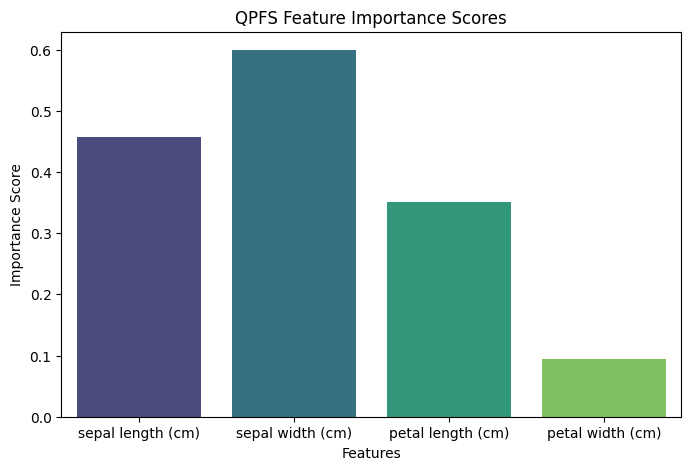

In [68]:
# Visualize feature importance
plt.figure(figsize=(8,5))
sns.barplot(x=iris.feature_names, y=x, palette="viridis")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("QPFS Feature Importance Scores")
plt.show()
